# Onset asynchrony

## Import dependencies, set constants etc.

In [1]:
from itertools import pairwise, combinations

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import statsmodels.formula.api as smf
from joblib import Parallel, delayed

import src.visualise.visualise_utils as vutils
from src import utils
from src.features.rhythm_features import ProportionalAsynchrony, get_beats_from_matched_onsets
from src.visualise.asynchrony_plots import *

## Load in data
We need to unserialise our list of onsets first

In [2]:
onsets: list = utils.load_corpus_from_files(fr'{utils.get_project_root()}/data/cambridge-jazz-trio-database-v02')

## Get position of marked beats
Now we can iterate through successive downbeats in a performance and express the position of each marked beat proportionally.

In [3]:
def process_track(track):
    asyncs = []
    # Get information from our OnsetMaker instance
    bandleader = track.item['bandleader']
    tempo = track.tempo
    temp = pd.DataFrame(track.summary_dict)
    # Obtain beats from matched onsets
    temp['beats_perf'] = get_beats_from_matched_onsets(track.summary_dict)
    idx = temp[temp['metre_auto'] == 1].index
    # Iterate through successive downbeats
    for downbeat1, downbeat2 in pairwise(idx):
        # Get all the beats marked between our two downbeats (beat 1 bar 1, beat 1 bar 2)
        bw = temp[(downbeat1 <= temp.index) & (temp.index < downbeat2)]
        sub = bw[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
        # Get the first downbeat of the first bar, and the last downbeat of the second
        first, last = temp[temp.index == downbeat1]['beats_perf'].iloc[0], temp[temp.index == downbeat2]['beats_perf'].iloc[0]
        # Scale our onsets to be proportional with our first and last values
        prop = (sub - first) / (last - first)
        # Drop values after 1/16th note or before 1/32nd note
        upper_bound = (((bw['metre_auto'] - 1) * 1/4) + 1/16)
        lower_bound = ((bw['metre_auto'] - 1) * 1/4) - 1/32
        for col in prop.columns:
            prop[col][(prop[col] < lower_bound) | (prop[col] > upper_bound)] = np.nan
        # Convert values to degrees
        prop *= 360
        prop = pd.concat([prop, bw['metre_auto']], axis=1)
        # Iterate through each column and add values to our list
        for instr in utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys():
            for _, val in prop[[instr, 'metre_auto']].dropna().iterrows():
                asyncs.append(dict(instr=instr, asynchrony=val[instr], beat=val['metre_auto'], bandleader=bandleader, tempo=tempo))
    return asyncs

In [4]:
with Parallel(n_jobs=-1, verbose=10) as par:
    asynchronies = par(delayed(process_track)(t) for t in onsets)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 24 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:    1.6s
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:    2.0s
[Parallel(n_jobs=-1)]: Done  24 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done  37 tasks      | elapsed:    3.1s
[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    3.5s
[Parallel(n_jobs=-1)]: Done  65 tasks      | elapsed:    4.1s
[Parallel(n_jobs=-1)]: Done  80 tasks      | elapsed:    4.5s
[Parallel(n_jobs=-1)]: Done  97 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 114 tasks      | elapsed:    5.9s
[Parallel(n_jobs=-1)]: Done 133 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 152 tasks      | elapsed:    7.4s
[Parallel(n_jobs=-1)]: Done 173 tasks      | elapsed:    8.1s
[Parallel(n_jobs=-1)]: Done 194 tasks      | elapsed:    8.7s
[Parallel(n_jobs=-1)]: Done 217 tasks      | elapsed:    9.8s
[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed:  

In [6]:
df = pd.DataFrame([x for xs in asynchronies for x in xs])

In [7]:
print(df[df['instr'] == 'piano'].shape)

(287680, 5)


## Clean dataset

In [9]:
# First, we sort the dataset so that instruments are in the order piano-bass-drums -- this is for hue mapping
df = (
    df.set_index('instr')
    .loc[utils.INSTRUMENTS_TO_PERFORMER_ROLES.keys()]
    .reset_index(drop=False)
)

In [10]:
# Offset the asynchrony column so that drums average beat 1 is shifted to 0
df['asynchrony_offset'] = df['asynchrony'] - df[(df['instr'] == 'drums') & (df['beat'] == 1)]['asynchrony'].mean()
# Adjust the asynchrony values so that asynchrony is independent of beat location
df['asynchrony_adjusted'] = (df['asynchrony'] / 360) - ((df['beat'] - 1) * 1/4)
# Adjust the offset beat values
df['asynchrony_adjusted_offset'] = (df['asynchrony_offset'] / 360) - ((df['beat'] - 1) * 1/4)

## Create circular plot of asynchrony by beat number

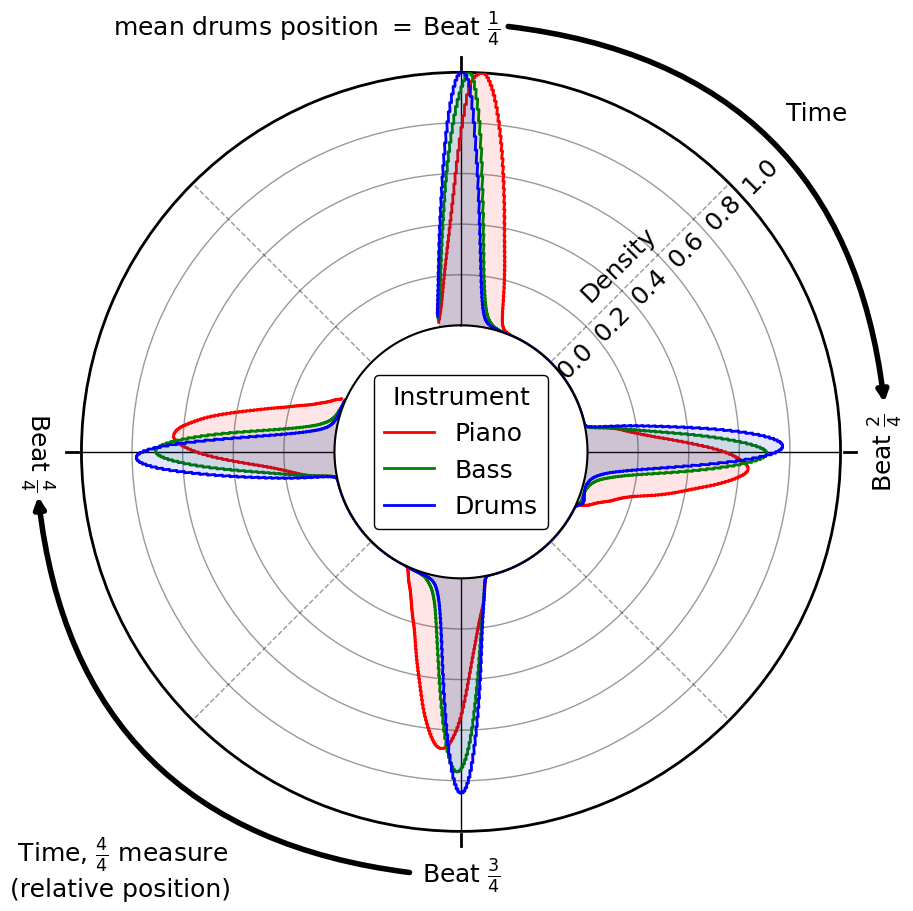

In [11]:
PolarPlotAsynchrony(df).create_plot()
plt.show()

## Bootstrap differences per instrument

In [12]:
grouped = df.groupby(['bandleader', 'instr', 'beat']).mean().reset_index(drop=False)
bootstraps = []
for i1, i2 in combinations(grouped['instr'].unique(), 2):
    print(i1, i2)
    val1 = grouped[grouped['instr'] == i1]['asynchrony_adjusted_offset']
    val2 = grouped[grouped['instr'] == i2]['asynchrony_adjusted_offset']
    true_mean = (val1.mean() - val2.mean()) * 100 * 4
    boots = [val1.sample(frac=1, random_state=s, replace=True).mean() - val2.sample(frac=1, random_state=s, replace=True).mean() for s in range(10)]
    bootstraps.append(dict(instr1=i1, instr2=i2, low=np.percentile(boots, 2.5) * 100 * 4, mean=true_mean, high=np.percentile(boots, 97.5) * 100 * 4))
pd.DataFrame(bootstraps)

bass drums
bass piano
drums piano


,instr1,instr2,low,mean,high
0,bass,drums,1.285094,1.555700,1.834092
1,bass,piano,-4.413848,-3.974956,-3.596327
2,drums,piano,-5.810825,-5.530656,-5.200635


## Model differences in piano 'lateness' vs tempo

In [38]:
tempo_res = []
for idx, grp in df.groupby(['bandleader', 'tempo']):
    piano = grp[grp['instr'] == 'piano']['asynchrony_adjusted_offset']
    for instr in ['bass', 'drums']:
        other = grp[grp['instr'] == instr]['asynchrony_adjusted_offset']
        # Express as percentage of a quarter note
        other_diff = (piano.mean() - other.mean()) * 400
        tempo_res.append(dict(bandleader=idx[0], tempo=idx[1], instr=instr, diff=other_diff))
tempo_df = pd.DataFrame(tempo_res).dropna()
tempo_df['tempo_standard'] = (tempo_df['tempo'] - tempo_df['tempo'].mean()) / tempo_df['tempo'].std()

In [39]:
tempo_df.head()

,bandleader,tempo,instr,diff,tempo_standard
0,Abdullah Ibrahim,118.080359,bass,3.319966,-1.607056
1,Abdullah Ibrahim,118.080359,drums,3.744642,-1.607056
2,Abdullah Ibrahim,121.851188,bass,3.350313,-1.528390
3,Abdullah Ibrahim,121.851188,drums,6.542874,-1.528390
4,Abdullah Ibrahim,134.210943,bass,-2.351046,-1.270545


In [40]:
tempo_df.shape

(2624, 5)

0
1
2
3
4
5
6
7
8
9


AttributeError: 'Line2D' object has no attribute 'set_edgecolor'

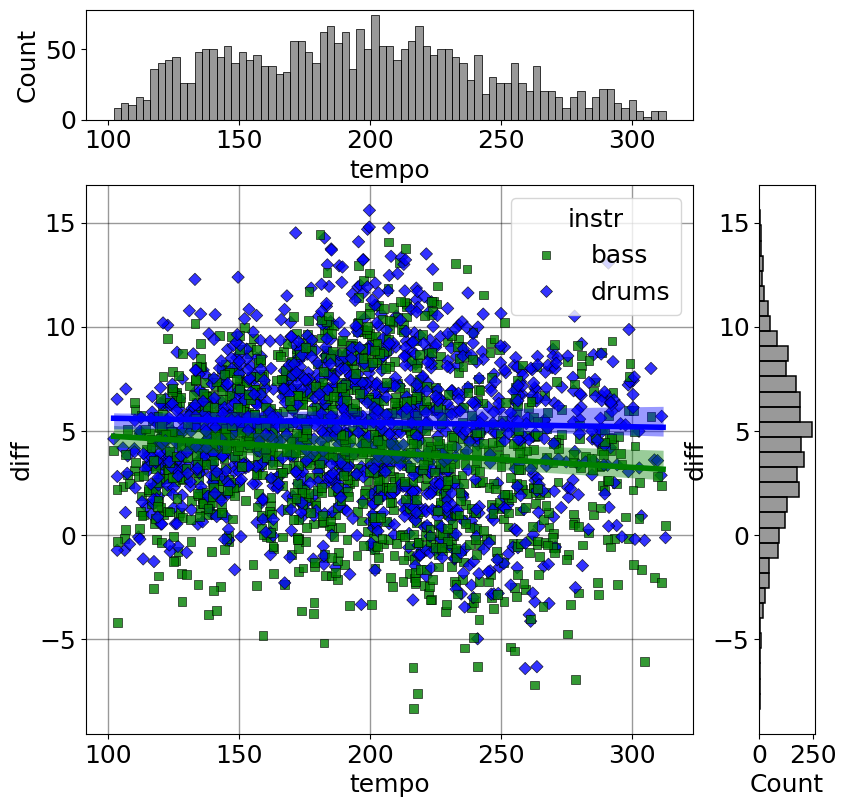

In [41]:
rp = RegPlotPianistAsynchrony(tempo_df)
rp.N_BOOT = 10
rp.create_plot()
plt.show()

In [42]:
md = smf.mixedlm(
    "diff ~ tempo_standard * C(instr, Treatment(reference='bass'))",
    data=tempo_df,
    groups=tempo_df['bandleader'],
    re_formula="0 + tempo_standard + C(instr, Treatment(reference='bass'))"
).fit()
print(md.summary())
# Variance explained by the fixed effects: we need to use md.predict() with the underlying data to get this
var_fixed = md.predict().var()
# Variance explained by the random effects
var_random = float(md.cov_re.to_numpy().mean())
# Variance of the residuals
var_resid = md.scale
# Total variance of the model
total_var = var_fixed + var_random + var_resid
# Calculate the r2 values and append to the model
print('conditional_r2:', (var_fixed + var_random) / total_var)
print('marginal_r2:', var_fixed / total_var)

                                                  Mixed Linear Model Regression Results
Model:                                       MixedLM                            Dependent Variable:                            diff      
No. Observations:                            2624                               Method:                                        REML      
No. Groups:                                  29                                 Scale:                                         7.6738    
Min. group size:                             10                                 Log-Likelihood:                                -6492.4994
Max. group size:                             508                                Converged:                                     Yes       
Mean group size:                             90.5                                                                                        
------------------------------------------------------------------------------------